In [1]:
using QuantumOptics
using NBInclude
using Einsum
#using DataFrames
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")

proj_MB_Int (generic function with 1 method)

In [2]:
param_dict=Dict{}()

LL = [8,10]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=LL[2]
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

1-element Vector{Vector{Vector{Int64}}}:
 [[1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]]

In [3]:
function Vpin(site, V0, site_number, LL)
        i_site = site_number[site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        VV[i_site, i_site] = -V0
        return VV
end

Vpin (generic function with 1 method)

In [4]:
function Vimp(sites,VV0,site_number,LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for (site, V0) in zip(sites,VV0) 
        VM += Vpin(site, V0, site_number, LL)
    end
    return VM
end

Vimp (generic function with 1 method)

In [5]:
function Vpin2(V0, xc, yc, w, sites, site_number, site_coord, LL)
        #xc, yc = site_coord[imp_site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        for site in sites
            i_site = site_number[site]
            x, y = site_coord[site]
            VV[i_site, i_site] = V0*(tanh(sqrt((x-xc)^2+(y-yc)^2)/w)^2-1)
        end
        return VV
end

Vpin2 (generic function with 1 method)

In [6]:
function Vimp2(VV0, XX, YY, ww, sites, site_number, site_coord, LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for (xc, yc, V0, w) in zip(XX,YY,VV0,ww) 
        VM +=  Vpin2(V0, xc, yc, w, sites, site_number, site_coord, LL)
    end
    return VM
end

Vimp2 (generic function with 1 method)

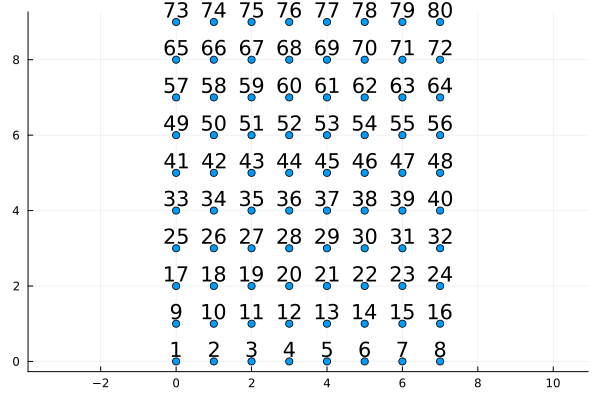

In [7]:
plot_points(sites, site_coord, site_number)

In [8]:
imp_site = sites[44]

3-element Vector{Int64}:
 3
 5
 1

In [9]:
xc, yc = site_coord[ imp_site ]

2-element Vector{Float64}:
 3.0
 5.0

In [27]:
V0 = 5
w = .5
#VimpM = Vpin(imp_site, V0, site_number, LL);
VimpM = Vpin2(V0, xc, yc, w, sites, site_number, site_coord, LL);

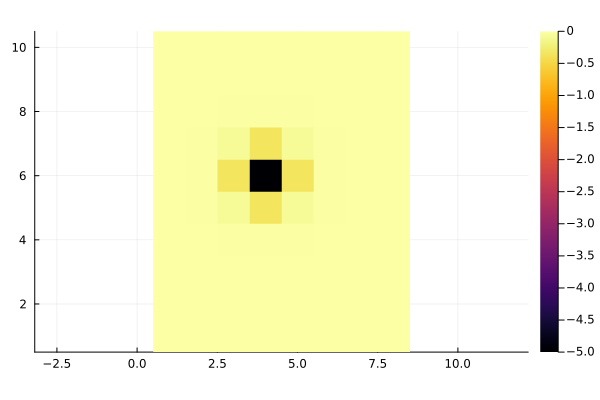

In [28]:
heatmap(reshape(diag(VimpM),8,10)', aspect_ratio=1)

In [84]:
imp_sites = [ sites[22], sites[60] ]
λ = 0.9
xc1, yc1 = site_coord[ imp_sites[1] ]
xc2, yc2 = site_coord[ imp_sites[2] ]
XX = [ xc1, xc2+.0 ]
YY = [ yc1, yc2+.0 ]
VV0       = [ V0*2, V0 ]
ww        = [ w, w ]

2-element Vector{Float64}:
 0.5
 0.5

In [85]:
#VimpM = Vimp(imp_sites, VV0, site_number, LL);
VimpM = Vimp2(VV0, XX, YY, ww, sites, site_number, site_coord, LL);

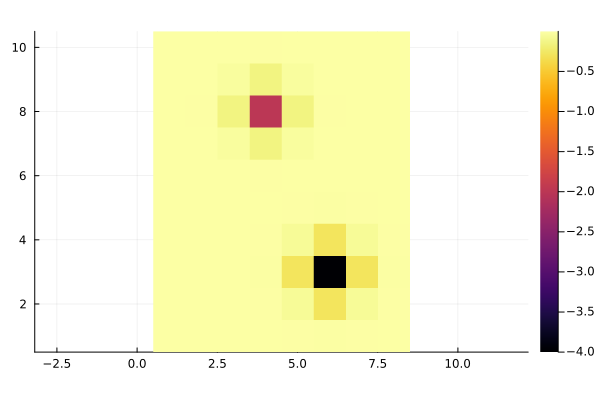

In [86]:
heatmap(reshape(diag(VimpM),8,10)', aspect_ratio=1)

In [87]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H_Kin = get_sp_op(basis, H_T)
Vimp_op = get_sp_op(basis, VimpM);

In [88]:
function H11(V0, w)
    VimpM = Vpin2(V0, xc, yc, w, sites, site_number, site_coord, LL);
    imp_sites = [ sites[22], sites[60] ]
    λ = 0.9
    xc1, yc1 = site_coord[ imp_sites[1] ]
    xc2, yc2 = site_coord[ imp_sites[2] ]
    XX = [ xc1, xc2+.0 ]
    YY = [ yc1, yc2+.0 ]
    VV0       = [ V0*1, V0 ]
    ww        = [ w, w ]
    basis = NLevelBasis(N) 
    param_dict["basis"] = basis;
    
    param_dict["model_H1"] = get_Hofstadter_hamiltonian
    
    H_T = get_Hofstadter_hamiltonian(param_dict)
    H_Kin = get_sp_op(basis, H_T)
    Vimp_op = get_sp_op(basis, VimpM)
    return H_Kin + Vimp_op
end
function HKin()
        basis = NLevelBasis(N) 
        param_dict["basis"] = basis;
        param_dict["model_H1"] = get_Hofstadter_hamiltonian
        H_T = get_Hofstadter_hamiltonian(param_dict)
        return get_sp_op(basis, H_T)
end

HKin (generic function with 1 method)

In [93]:
V0 = .2
H_Kin = HKin()
EE_Kin, UU_Kin = eigen(dense(H_Kin).data);
H1 = H11(V0,w)
EE, UU = eigen(dense(H1).data);
EE, UUS = eigenstates(dense(H1));
V02 = .10
H12 = H11(V02,w)
EE2, UUS2 = eigenstates(dense(H12));

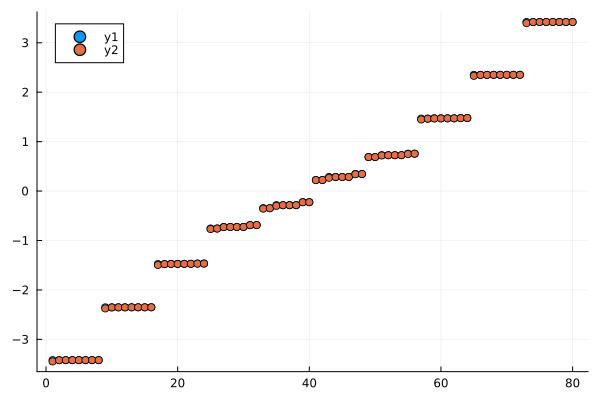

In [94]:
scatter(EE_Kin)
scatter!(EE)
#ylims!(-4,-3)

In [79]:
EE[1:3]

3-element Vector{Float64}:
 -3.894880915623251
 -3.438018806978176
 -3.424060347726734

In [80]:
prs=[]
for i in 1:prod(LL)
    pr = sum( ( real( diag( dm(UUS[i]).data ) ) ).^2 )
    push!(prs,pr)
end
prs2=[]
for i in 1:prod(LL)
    pr2 = sum( ( real( diag( dm(UUS2[i]).data ) ) ).^2 )
    push!(prs2,pr2)
end

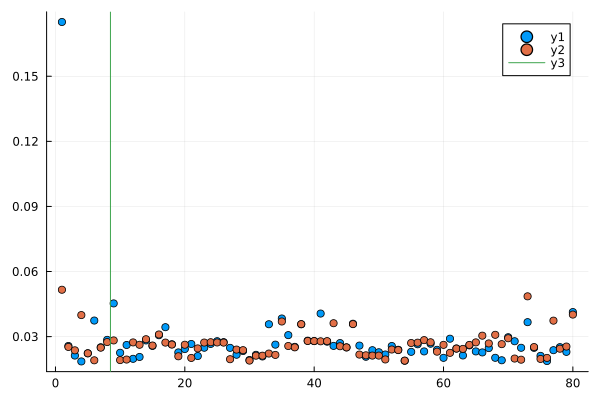

In [81]:
scatter(prs)
scatter!(prs2)
vline!([8.5])

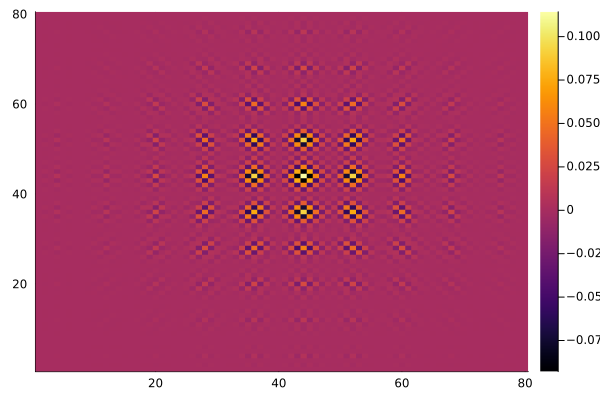

In [100]:
heatmap(real(dm(UUS[1]).data))

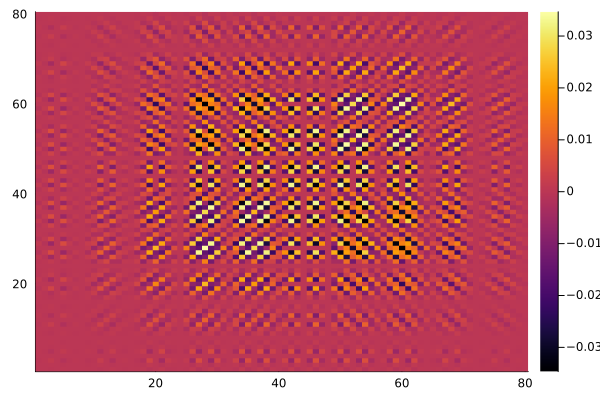

In [101]:
heatmap(real(dm(UUS[2]).data))

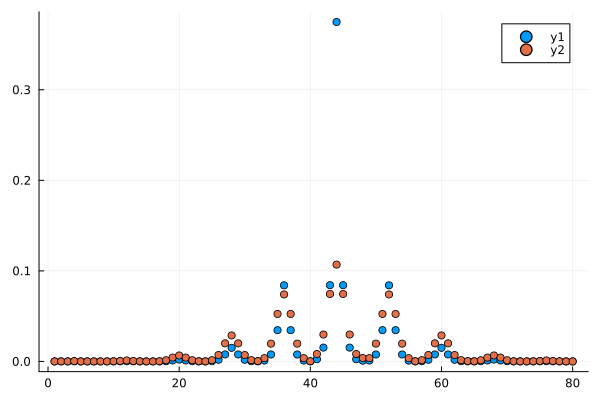

In [82]:
scatter(  real( diag( dm(UUS[1]).data ) ) )
scatter!(  real( diag( dm(UUS2[1]).data ) ) )

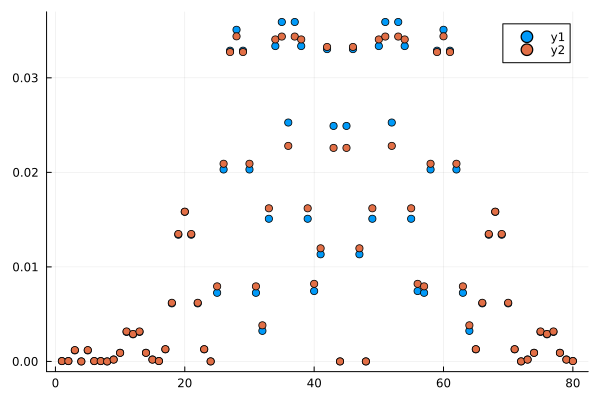

In [83]:
scatter(  real( diag( dm(UUS[2]).data ) ) )
scatter!(  real( diag( dm(UUS2[2]).data ) ) )